In [7]:
%pip install pandas numpy scikit-learn matplotlib seaborn




[notice] A new release of pip is available: 24.2 -> 25.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [10]:
df = pd.read_csv('train.csv')


In [11]:
print(df.head())
print(df.info())
print(df.describe())


   User_ID Product_ID Gender   Age  Occupation City_Category  \
0  1000001  P00069042      F  0-17          10             A   
1  1000001  P00248942      F  0-17          10             A   
2  1000001  P00087842      F  0-17          10             A   
3  1000001  P00085442      F  0-17          10             A   
4  1000002  P00285442      M   55+          16             C   

  Stay_In_Current_City_Years  Marital_Status  Product_Category_1  \
0                          2               0                   3   
1                          2               0                   1   
2                          2               0                  12   
3                          2               0                  12   
4                         4+               0                   8   

   Product_Category_2  Product_Category_3  Purchase  
0                 NaN                 NaN      8370  
1                 6.0                14.0     15200  
2                 NaN                 NaN   

In [12]:
print(df.isnull().sum())



User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            173638
Product_Category_3            383247
Purchase                           0
dtype: int64


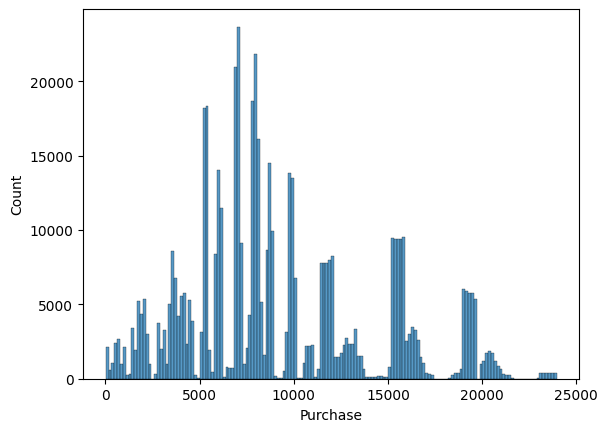

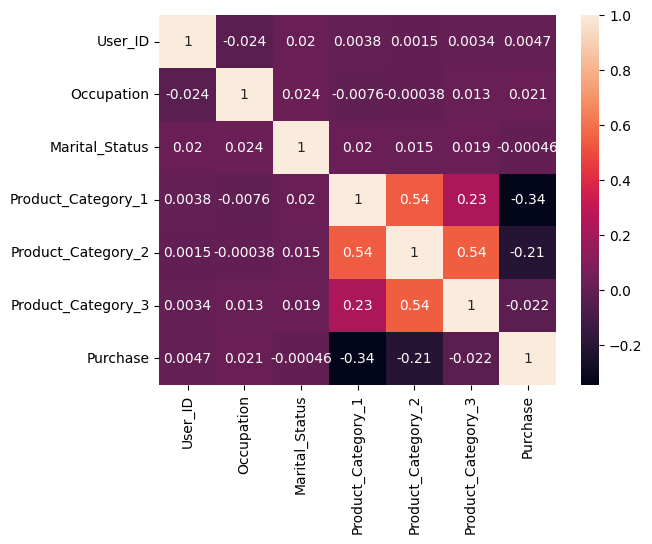

In [13]:
sns.histplot(df['Purchase'])
plt.show()

# Select only numeric columns
numeric_df = df.select_dtypes(include=[np.number])

# Now correlation will work
sns.heatmap(numeric_df.corr(), annot=True)
plt.show()



In [14]:
# Separate numeric and non-numeric (categorical) columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
categorical_cols = df.select_dtypes(exclude=[np.number]).columns

# Fill numeric columns with median
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Fill categorical columns with mode
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])
print(df.isnull().sum())

User_ID                       0
Product_ID                    0
Gender                        0
Age                           0
Occupation                    0
City_Category                 0
Stay_In_Current_City_Years    0
Marital_Status                0
Product_Category_1            0
Product_Category_2            0
Product_Category_3            0
Purchase                      0
dtype: int64


In [15]:
df = pd.get_dummies(df, drop_first=True)

In [16]:
X = df.drop('Purchase', axis=1)
y = df['Purchase']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [19]:
base_models = [
    ('lr', LinearRegression()),
    ('ridge', Ridge(alpha=1.0)),
    ('lasso', Lasso(alpha=0.1)),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('gbr', GradientBoostingRegressor(n_estimators=100, random_state=42))
]


In [20]:
# Sample only 20% data
X_sample = X_train.sample(frac=0.05, random_state=42)
y_sample = y_train.loc[X_sample.index]

# Use light models first
base_models = [
    ('lr', LinearRegression()),
    ('ridge', Ridge()),
    ('lasso', Lasso()),
    ('rf', RandomForestRegressor(n_estimators=5, random_state=42)),  # Reduce the number of trees
    ('gbr', GradientBoostingRegressor(n_estimators=5, random_state=42))  # Reduce the number of trees
]


kf = KFold(n_splits=3, shuffle=True, random_state=42)

for name, model in base_models:
    print(f"Training {name}...")
    scores = cross_val_score(model, X_sample, y_sample, scoring='neg_root_mean_squared_error', cv=kf, n_jobs=1)
    print(f"{name}: RMSE: {-scores.mean():.4f}")


Training lr...
lr: RMSE: 2961.5140
Training ridge...
ridge: RMSE: 2941.7974
Training lasso...
lasso: RMSE: 3286.9705
Training rf...
rf: RMSE: 3091.5524
Training gbr...
gbr: RMSE: 4236.5956


In [21]:
stacking_model = StackingRegressor(
    estimators=base_models,
    final_estimator=GradientBoostingRegressor(n_estimators=100, random_state=42)
)


In [22]:
stacking_model.fit(X_train.sample(frac=0.05, random_state=42), y_train.loc[X_sample.index])


StackingRegressor(estimators=[('lr', LinearRegression()), ('ridge', Ridge()),
                              ('lasso', Lasso()),
                              ('rf',
                               RandomForestRegressor(n_estimators=5,
                                                     random_state=42)),
                              ('gbr',
                               GradientBoostingRegressor(n_estimators=5,
                                                         random_state=42))],
                  final_estimator=GradientBoostingRegressor(random_state=42))

In [23]:
y_pred = stacking_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test R2 Score: {r2:.4f}")


Test RMSE: 2782.7580
Test R2 Score: 0.6918


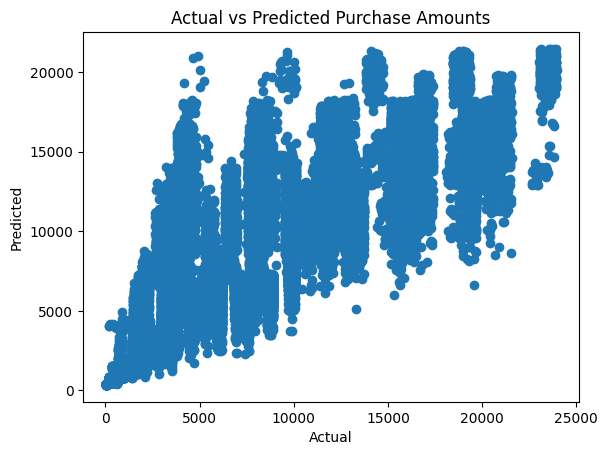

In [24]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Purchase Amounts')
plt.show()


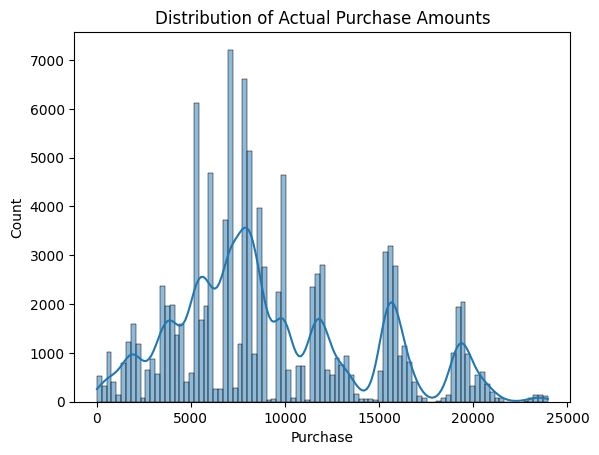

In [25]:
import seaborn as sns
sns.histplot(y_test, kde=True)
plt.title('Distribution of Actual Purchase Amounts')
plt.show()
